In [1]:
# ACQUIRE
import numpy as np
import pandas as pd
import unicodedata
import re
import nltk
import json 
import warnings
warnings.filterwarnings('ignore')

# PREPARE
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import prepare
from sklearn.model_selection import train_test_split

# EXPLORE
import explore
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from wordcloud import WordCloud

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=15)

# MODELING
from numpy.random import choice
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION
from sklearn.metrics import classification_report, accuracy_score

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamgomez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Acquire

We acquire the initial dataframe of the data using the pandas `.read_json()` method. 

We read `data.json` which was acquired by running the acquire.py script using the following command in the MacOS terminal:

        python acquire.py

In [3]:
df = pd.read_json('data.json')
df

,repo,language,readme_contents
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w..."
2,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...
3,beetbox/beets,Python,.. image:: https://img.shields.io/pypi/v/beets...
4,scottschiller/SoundManager2,JavaScript,# SoundManager 2: JavaScript Sound for the Web...
...,...,...,...
197,andyxialm/CutoLoadingView,Java,#CutoLoadingView\n[![](https://jitpack.io/v/an...
198,rjsvieira/morphos,Java,# Morphos\n\n![Current Version](https://img.sh...
199,tuesda/SubmitDemo,Java,This is library project with a custom view tha...
200,avenwu/support,Java,Support\n========\n\nCustom Android support li...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             202 non-null    object
 1   language         191 non-null    object
 2   readme_contents  201 non-null    object
dtypes: object(3)
memory usage: 4.9+ KB


# Prepare

Utilizing the `prep_data()` function from our prepare.py file, we modify the dataframe by:

1) Cleaning the raw strings in the readme_contents column by eliminating non-alphanumeric characters  
2) Removing single character words from the raw strings  
3) Tokenizing the words using `TokTokTokenizer`  
4) Adding a `stemmed` column made from the use of `PorterStemmer()` from the `nltk` library  
5) Adding a `lemmatized` column made from the use of `WordNetLemmatizer` from the `nltk` library  
6) Removing stopwords from the lemmatized results to create the `clean` column  
- Includes the standard english stopwords and the additional words: 

            github, project, name, library, 00s, http, com, org, license, www, file, use
            
7) Adding a column `stopwords_removed` showing a count of the number of stopwords removed from lemmatized string  
8) Adding a column `doc_length` showing the total number of words in the clean strings  
9) Adding a column containing lists of the words used in each cleaned string  
10) Dropping any observations that are only instance of a language (this is necessary to stratify the dataframe when splitting later)  
11) Dropping any observations with missing data

In [5]:
df = prepare.prep_data(df, 'readme_contents')
df

,repo,language,readme_contents,stemmed,lemmatized,clean,stopwords_removed,doc_length,words
0,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movi applic for thi project we will be build a...,movie application for this project we will be ...,movie application building single page movie a...,386,406,"[movie, application, building, single, page, m..."
1,torvalds/linux,C,Linux kernel\n============\n\nThere are severa...,linux kernel there are sever guid for kernel d...,linux kernel there are several guide for kerne...,linux kernel several guide kernel developer us...,45,65,"[linux, kernel, several, guide, kernel, develo..."
2,beetbox/beets,Python,.. image:: https://img.shields.io/pypi/v/beets...,imag http img shield io pypi v beet svg target...,image http img shield io pypi v beet svg targe...,image img shield io pypi v beet svg target pyp...,274,455,"[image, img, shield, io, pypi, v, beet, svg, t..."
3,scottschiller/SoundManager2,JavaScript,# SoundManager 2: JavaScript Sound for the Web...,soundmanag javascript sound for the web by wra...,soundmanager javascript sound for the web by w...,soundmanager javascript sound web wrapping ext...,339,615,"[soundmanager, javascript, sound, web, wrappin..."
4,CreateJS/SoundJS,JavaScript,# SoundJS\r\n\r\nSoundJS is a library to make ...,soundj soundj is a librari to make work with a...,soundjs soundjs is a library to make working w...,soundjs soundjs make working audio web easier ...,198,314,"[soundjs, soundjs, make, working, audio, web, ..."
...,...,...,...,...,...,...,...,...,...
180,andyxialm/CutoLoadingView,Java,#CutoLoadingView\n[![](https://jitpack.io/v/an...,cutoloadingview http jitpack io v andyxialm cu...,cutoloadingview http jitpack io v andyxialm cu...,cutoloadingview jitpack io v andyxialm cutoloa...,78,132,"[cutoloadingview, jitpack, io, v, andyxialm, c..."
181,rjsvieira/morphos,Java,# Morphos\n\n![Current Version](https://img.sh...,morpho current version http img shield io badg...,morphos current version http img shield io bad...,morphos current version img shield io badge cu...,209,674,"[morphos, current, version, img, shield, io, b..."
182,tuesda/SubmitDemo,Java,This is library project with a custom view tha...,thi is librari project with a custom view that...,this is library project with a custom view tha...,custom view implement concept submit button dr...,17,92,"[custom, view, implement, concept, submit, but..."
183,avenwu/support,Java,Support\n========\n\nCustom Android support li...,support custom android support librari includ ...,support custom android support library include...,support custom android support include useful ...,97,261,"[support, custom, android, support, include, u..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   repo               185 non-null    object
 1   language           185 non-null    object
 2   readme_contents    185 non-null    object
 3   stemmed            185 non-null    object
 4   lemmatized         185 non-null    object
 5   clean              185 non-null    object
 6   stopwords_removed  185 non-null    int64 
 7   doc_length         185 non-null    int64 
 8   words              185 non-null    object
dtypes: int64(2), object(7)
memory usage: 13.1+ KB


With the data cleaned and prepped, we can see the total number of observations available for analysis.

## Splitting the Data

In [7]:
train_validate, test = train_test_split(df, stratify = df.language, test_size = .15, random_state= 123)
train, validate = train_test_split(train_validate, stratify = train_validate.language, test_size = .20, random_state = 123)

In [8]:
train.shape, validate.shape, test.shape

((125, 9), (32, 9), (28, 9))

# Exploration

### Which languages are represented in the data?

In [9]:
train.language.value_counts()

HTML                20
Ruby                19
JavaScript          19
Python              19
C++                 19
Java                16
Jupyter Notebook     4
C#                   2
C                    2
TypeScript           2
CSS                  2
Scala                1
Name: language, dtype: int64

### What are the most common words in READMEs?

In [10]:
# Create a single massive string containing every word used in every observation
all_words = ' '.join(train.clean)

In [11]:
# Create a dataframe from this single combined string
all_words_df = pd.DataFrame(all_words.split())

In [12]:
# Identify the top ten most frequently used words
all_words_df.value_counts().head(10)

learning      545
data          506
machine       462
python        345
html          307
code          268
build         252
tensorflow    248
io            239
j             232
dtype: int64

In [13]:
# Creating strings containing all of the words associated with several top languages
html_words = ' '.join(train[train.language=='HTML'].clean)
c_plus_plus_words = ' '.join(train[train.language=='C++'].clean)
python_words = ' '.join(train[train.language=='Python'].clean)
javascript_words = ' '.join(train[train.language=='JavaScript'].clean)
ruby_words = ' '.join(train[train.language=='Ruby'].clean)
java_words = ' '.join(train[train.language=='Java'].clean)

In [14]:
# Creating dataframes from those strings
javascript_df = pd.DataFrame(javascript_words.split())
python_df = pd.DataFrame(python_words.split())
ruby_df = pd.DataFrame(ruby_words.split())
html_df = pd.DataFrame(html_words.split())
c_plus_plus_df = pd.DataFrame(c_plus_plus_words.split())
java_df = pd.DataFrame(java_words.split())

In [15]:
# Determining word frequency for each dataframe
javascript_freq = javascript_df.value_counts()
python_freq = python_df.value_counts()
ruby_freq = ruby_df.value_counts()
html_freq = html_df.value_counts()
c_plus_plus_freq = c_plus_plus_df.value_counts()
java_freq = java_df.value_counts()
all_freq = all_words_df.value_counts()

In [16]:
word_counts = (pd.concat([all_freq, javascript_freq, python_freq, ruby_freq, html_freq, c_plus_plus_freq, java_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'ruby', 'html', 'c_plus_plus', 'java'], axis=1, inplace=False) 
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
learning,545,1,529,3,0,10,0
data,506,11,283,38,122,21,2
machine,462,3,423,21,2,8,0
python,345,0,272,0,3,43,0
html,307,26,148,16,27,24,4
code,268,17,119,35,22,35,10
build,252,28,30,11,13,123,8
tensorflow,248,0,57,0,0,185,0
io,239,46,93,14,21,37,11


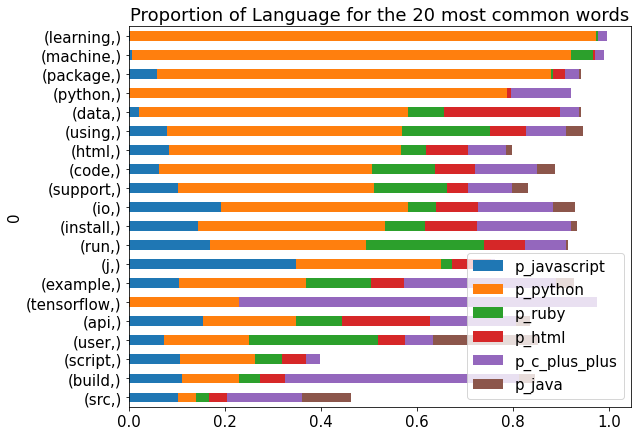

In [17]:
explore.most_common_words_props(word_counts)

### Which words show up the most in each language versus all words?

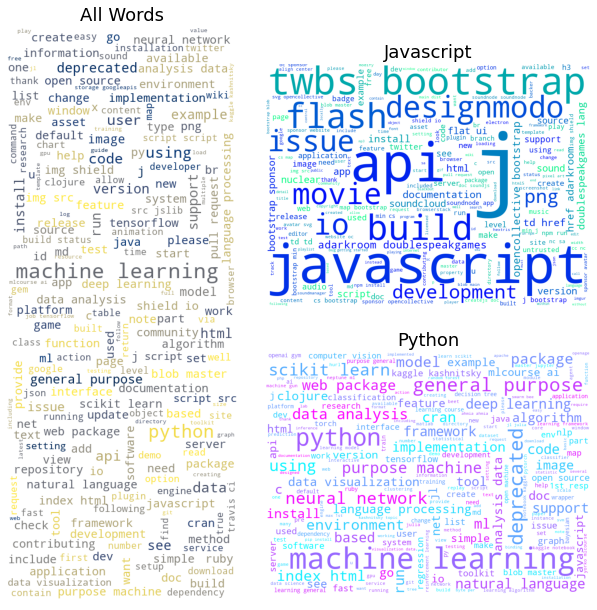

In [18]:
explore.word_cloud_1(all_words, javascript_words, python_words)

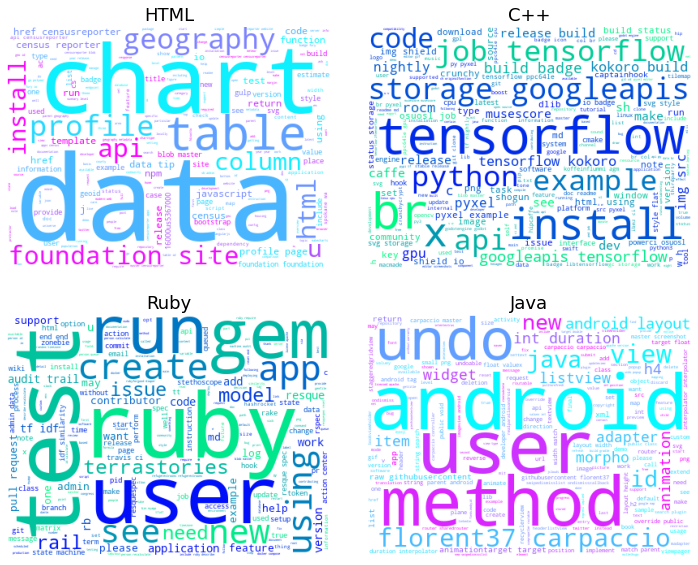

In [19]:
explore.word_cloud_2(html_words, ruby_words, c_plus_plus_words, java_words)

### What does the distribution of IDFs look like for the most common words?

In [20]:
explore.idf(all_words_df, train)

,word,total_count,num_of_documents,idf_value
0,learning,545,15,2.120264
1,data,506,38,1.190728
2,machine,462,20,1.832581
3,python,345,28,1.496109
4,html,307,52,0.877070
5,code,268,66,0.638659
6,build,252,52,0.877070
7,tensorflow,248,5,3.218876
8,io,239,53,0.858022
9,j,232,26,1.570217


### Are there any words that uniquely identify a language of a project?

In [21]:
# Words that are uniquely attached to JavaScript readmes
word_counts[(word_counts.javascript != 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='javascript', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
td,46,46,0,0,0,0,0
twbs,35,35,0,0,0,0,0
designmodo,33,33,0,0,0,0,0
movie,30,30,0,0,0,0,0
soundnode,28,28,0,0,0,0,0
nuclear,27,27,0,0,0,0,0
flash,27,27,0,0,0,0,0
adarkroom,26,26,0,0,0,0,0
opencollective,27,26,0,0,0,0,0


In [22]:
# Words that are unique attached to Python readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python != 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='python', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
bee,147,0,147,0,0,0,0
kaggle,129,0,126,0,0,0,0
scikit,122,0,119,0,0,0,0
cran,74,0,74,0,0,0,0
ahmia,74,0,74,0,0,0,0
nlp,65,0,65,0,0,0,0
gym,57,0,57,0,0,0,0
jl,57,0,57,0,0,0,0
julia,56,0,56,0,0,0,0


In [23]:
# Words that are unique attached to Ruby readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby != 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='ruby', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
resque,57,0,0,57,0,0,0
terrastories,35,0,0,35,0,0,0
resquespec,30,0,0,30,0,0,0
idf,29,0,0,29,0,0,0
refugerestrooms,28,0,0,28,0,0,0
diaper,28,0,0,28,0,0,0
myapp,27,0,0,27,0,0,0
zonebie,26,0,0,26,0,0,0
stethoscope,26,0,0,26,0,0,0


In [24]:
# Words that are unique attached to HTML readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html != 0) & (word_counts.c_plus_plus == 0) & (word_counts.java == 0)].sort_values(by='html', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
censusreporter,55,0,0,0,55,0,0
census,50,0,0,0,50,0,0
geography,47,0,0,0,47,0,0
reporter,21,0,0,0,21,0,0
geoid,18,0,0,0,18,0,0
wa,15,0,0,0,15,0,0
spokane,14,0,0,0,14,0,0
county,14,0,0,0,14,0,0
gulp,13,0,0,0,13,0,0


In [25]:
# Words that are unique attached to C++ readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus != 0) & (word_counts.java == 0)].sort_values(by='c_plus_plus', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
pyxel,111,0,0,0,0,111,0
googleapis,41,0,0,0,0,41,0
musescore,39,0,0,0,0,39,0
rocm,34,0,0,0,0,34,0
kokoro,28,0,0,0,0,28,0
agm,24,0,0,0,0,24,0
godot,23,0,0,0,0,23,0
crunchy,22,0,0,0,0,22,0
godotengine,21,0,0,0,0,21,0


In [26]:
# Words that are unique attached to java readmes
word_counts[(word_counts.javascript == 0) & (word_counts.python == 0) & (word_counts.ruby == 0) & (word_counts.html == 0) & (word_counts.c_plus_plus == 0) & (word_counts.java != 0)].sort_values(by='java', ascending=False).head(10)

,all,javascript,python,ruby,html,c_plus_plus,java
0,,,,,,,
carpaccio,62,0,0,0,0,0,62
florent37,38,0,0,0,0,0,38
interpolator,26,0,0,0,0,0,26
swipedismisslist,25,0,0,0,0,0,25
listview,19,0,0,0,0,0,19
morphos,18,0,0,0,0,0,18
animationtarget,18,0,0,0,0,0,18
valuex,15,0,0,0,0,0,15
popup,15,0,0,0,0,0,15


### Does the length of the README vary by programming language?

In [27]:
train.groupby('language').doc_length.mean().sort_values(ascending=False)

language
TypeScript          2227.500000
Python              1585.368421
Ruby                 450.578947
C++                  396.894737
C#                   395.000000
JavaScript           343.789474
Java                 286.750000
Scala                283.000000
HTML                 265.800000
C                    210.000000
CSS                  170.000000
Jupyter Notebook     106.750000
Name: doc_length, dtype: float64

In [28]:
explore.t_test_loop('doc_length', train)

----------------
doc_length T-Test: TypeScript & Ruby
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of TypeScript and Ruby
H_a: There is a difference in the mean doc_length of TypeScript and Ruby


p-value: 0.0018824887340140337
t-statistic: 3.3000440250787317
We reject the null hypothesis


The mean readme doc_length for TypeScript is larger than Ruby

 

----------------
doc_length T-Test: TypeScript & C++
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of TypeScript and C++
H_a: There is a difference in the mean doc_length of TypeScript and C++


p-value: 0.001967416577897316
t-statistic: 3.2804469201019173
We reject the null hypothesis


The mean readme doc_length for TypeScript is larger than C++

 

----------------
doc_length T-Test: TypeScript & JavaScript
----------------
Hypotheses:
H_0: There is no difference in the mean doc_length of TypeScript and JavaScript
H_a: There is a difference in the mean doc_length 

### Do different programming languages use a different number of unique words?

In [29]:
unique_word_count = {}

train_language_list = list(train.groupby('language')['doc_length'].mean().sort_values(ascending=False).index)

for language in train_language_list:
    unique_word_count[language] = len(set(' '.join(train[train.language==language].clean).split()))

In [30]:
unique_word_count = pd.DataFrame.from_dict(unique_word_count, orient='index').rename(columns={0: 'num_unique_words'})

In [31]:
unique_word_count.sort_values(by='num_unique_words', ascending=False)

,num_unique_words
Python,6144
Ruby,2257
C++,2109
JavaScript,1973
HTML,1656
TypeScript,1289
Java,1278
C#,339
Jupyter Notebook,267
C,223


While this gives us a total count of the number of unique words each programming language has connected to it, this is likely to be correlated both to the total document length AND the number of observations that each language has. Languages with more observations likely have more opportunities to expand the unique word list. 

A better metric would be the average number of unique words that each language has. To do this we will need to add a column to our dataframe.

In [32]:
train['unique_word_count'] = train.words.apply(lambda x: len(set(x)))

In [33]:
train.head(1)

,repo,language,readme_contents,stemmed,lemmatized,clean,stopwords_removed,doc_length,words,unique_word_count
26,censusreporter/censusreporter,HTML,About Census Reporter\n=====================\n...,about censu report the unit state censu bureau...,about census reporter the united state census ...,census reporter united state census bureau pro...,1573,2789,"[census, reporter, united, state, census, bure...",861


Now we can run a similar set of t-tests to compare the unique word count for each programming language

In [34]:
train.groupby('language').unique_word_count.mean().sort_values(ascending=False)

language
TypeScript          672.500000
Python              480.368421
Ruby                207.473684
C#                  187.000000
JavaScript          179.421053
C++                 169.947368
Scala               151.000000
Java                129.562500
C                   120.500000
HTML                118.300000
CSS                 102.500000
Jupyter Notebook     71.500000
Name: unique_word_count, dtype: float64

In [35]:
explore.t_test_loop('unique_word_count', train)

----------------
unique_word_count T-Test: TypeScript & Ruby
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of TypeScript and Ruby
H_a: There is a difference in the mean unique_word_count of TypeScript and Ruby


p-value: 0.006524370238190248
t-statistic: 2.7387672495326547
We reject the null hypothesis


The mean readme unique_word_count for TypeScript is larger than Ruby

 

----------------
unique_word_count T-Test: TypeScript & JavaScript
----------------
Hypotheses:
H_0: There is no difference in the mean unique_word_count of TypeScript and JavaScript
H_a: There is a difference in the mean unique_word_count of TypeScript and JavaScript


p-value: 0.0026118583716749164
t-statistic: 3.1541604406775816
We reject the null hypothesis


The mean readme unique_word_count for TypeScript is larger than JavaScript

 

----------------
unique_word_count T-Test: TypeScript & C++
----------------
Hypotheses:
H_0: There is no difference in the mean unique

# Model

In [36]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

In [37]:
# X_train, X_validate, X_test are transformed to sparse array representing TF-IDF values for every word

X_train = tfidf.fit_transform(train.clean)

X_validate = tfidf.transform(validate.clean)

X_test = tfidf.transform(test.clean)

In [38]:
# y_train, y_validate, y_test are simply the actual language labels

y_train = train.language
y_validate = validate.language
y_test = test.language

## Baseline

We will create two baseline models. 

The first will predict a language at random using weighted probabilities based on the distribution of the languages in the train dataset. 

The second will be based on the most common language in the train dataset.

### Baseline Mode: Weighted Random Selection

In [39]:
baseline_train_pred_random = explore.baseline_language_model(train, num_observations = train.language.shape[0])

In [40]:
train_results = pd.DataFrame(dict(actual=y_train))
train_results['base_random'] = baseline_train_pred_random
train_results

,actual,base_random
26,HTML,JavaScript
135,HTML,HTML
77,Ruby,Jupyter Notebook
84,C++,Jupyter Notebook
1,C,C++
...,...,...
16,JavaScript,Ruby
5,C++,JavaScript
48,JavaScript,Java
147,C++,Java


In [41]:
print('Baseline Model: Weighted Random Selection')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.base_random, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.base_random))

Baseline Model: Weighted Random Selection
Accuracy: 11.20%
---
Confusion Matrix
actual            C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
base_random                                                                   
C                 0   0    0    0     0     1           0                 0   
C#                0   0    0    0     1     0           1                 0   
C++               2   0    3    0     3     2           4                 0   
CSS               0   0    0    0     1     0           0                 0   
HTML              0   0    1    2     2     2           3                 1   
Java              0   0    2    0     1     2           4                 1   
JavaScript        0   0    5    0     6     3           2                 1   
Jupyter Notebook  0   0    3    0     0     1           1                 0   
Python            0   1    1    0     4     2           3                 0   
Ruby              0   1    3    0     2     1      

### Baseline Model: Mode Selection

In [42]:
train_results['base_mode'] = train.language.value_counts().idxmax()
train_results

,actual,base_random,base_mode
26,HTML,JavaScript,HTML
135,HTML,HTML,HTML
77,Ruby,Jupyter Notebook,HTML
84,C++,Jupyter Notebook,HTML
1,C,C++,HTML
...,...,...,...
16,JavaScript,Ruby,HTML
5,C++,JavaScript,HTML
48,JavaScript,Java,HTML
147,C++,Java,HTML


In [43]:
print('Baseline Model: Mode Selection')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.base_mode, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.base_mode))

Baseline Model: Mode Selection
Accuracy: 16.00%
---
Confusion Matrix
actual     C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
base_mode                                                                      
HTML       2   2   19    2    20    16          19                 4      19   

actual     Ruby  Scala  TypeScript  
base_mode                           
HTML         19      1           2  
---
                  precision    recall  f1-score   support

               C       0.00      0.00      0.00         2
              C#       0.00      0.00      0.00         2
             C++       0.00      0.00      0.00        19
             CSS       0.00      0.00      0.00         2
            HTML       0.16      1.00      0.28        20
            Java       0.00      0.00      0.00        16
      JavaScript       0.00      0.00      0.00        19
Jupyter Notebook       0.00      0.00      0.00         4
          Python       0.00      0.00      0.00     

## Logistic Regression

In [44]:
lm = LogisticRegression().fit(X_train, y_train)

In [45]:
train_results['lm_predicted'] = lm.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted
26,HTML,JavaScript,HTML,HTML
135,HTML,HTML,HTML,HTML
77,Ruby,Jupyter Notebook,HTML,Ruby
84,C++,Jupyter Notebook,HTML,C++
1,C,C++,HTML,Python
...,...,...,...,...
16,JavaScript,Ruby,HTML,JavaScript
5,C++,JavaScript,HTML,C++
48,JavaScript,Java,HTML,JavaScript
147,C++,Java,HTML,C++


In [46]:
print('Logistic Regression')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.lm_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.lm_predicted))

Logistic Regression
Accuracy: 89.60%
---
Confusion Matrix
actual        C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
lm_predicted                                                              
C++           1   0   19    0     0     0           0                 1   
HTML          0   2    0    1    20     0           0                 0   
Java          0   0    0    0     0    16           0                 0   
JavaScript    0   0    0    1     0     0          19                 0   
Python        1   0    0    0     0     0           0                 2   
Ruby          0   0    0    0     0     0           0                 1   

actual        Python  Ruby  Scala  TypeScript  
lm_predicted                                   
C++                0     0      0           0  
HTML               0     0      1           0  
Java               0     0      0           0  
JavaScript         0     0      0           2  
Python            19     0      0           0  
Ruby 

## Decision Tree

In [47]:
clf = DecisionTreeClassifier(max_depth = 15, random_state = 123).fit(X_train, y_train)

In [48]:
train_results['clf_predicted'] = clf.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted
26,HTML,JavaScript,HTML,HTML,HTML
135,HTML,HTML,HTML,HTML,HTML
77,Ruby,Jupyter Notebook,HTML,Ruby,Ruby
84,C++,Jupyter Notebook,HTML,C++,C++
1,C,C++,HTML,Python,C
...,...,...,...,...,...
16,JavaScript,Ruby,HTML,JavaScript,JavaScript
5,C++,JavaScript,HTML,C++,C++
48,JavaScript,Java,HTML,JavaScript,JavaScript
147,C++,Java,HTML,C++,C++


In [49]:
print('Decision Tree')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.clf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.clf_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.clf_predicted))

Decision Tree
Accuracy: 94.40%
---
Confusion Matrix
actual            C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
clf_predicted                                                                 
C                 2   0    0    0     0     0           0                 0   
C#                0   2    0    0     0     0           0                 0   
C++               0   0   17    0     0     0           0                 0   
CSS               0   0    0    2     0     0           0                 1   
HTML              0   0    2    0    20     0           0                 2   
Java              0   0    0    0     0    16           0                 0   
JavaScript        0   0    0    0     0     0          19                 0   
Jupyter Notebook  0   0    0    0     0     0           0                 1   
Python            0   0    0    0     0     0           0                 0   
Ruby              0   0    0    0     0     0           0                 0   


## Random Forest

In [50]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123).fit(X_train, y_train)

In [51]:
train_results['rf_predicted'] = rf.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted
26,HTML,JavaScript,HTML,HTML,HTML,HTML
135,HTML,HTML,HTML,HTML,HTML,HTML
77,Ruby,Jupyter Notebook,HTML,Ruby,Ruby,Ruby
84,C++,Jupyter Notebook,HTML,C++,C++,C++
1,C,C++,HTML,Python,C,HTML
...,...,...,...,...,...,...
16,JavaScript,Ruby,HTML,JavaScript,JavaScript,JavaScript
5,C++,JavaScript,HTML,C++,C++,C++
48,JavaScript,Java,HTML,JavaScript,JavaScript,JavaScript
147,C++,Java,HTML,C++,C++,C++


In [52]:
print('Random Forest Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.rf_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.rf_predicted))

Random Forest Model
Accuracy: 80.00%
---
Confusion Matrix
actual        C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
rf_predicted                                                              
C++           0   0   13    0     0     0           0                 0   
HTML          1   2    5    2    19     1           4                 3   
Java          0   0    0    0     1    15           0                 0   
JavaScript    1   0    0    0     0     0          15                 0   
Python        0   0    1    0     0     0           0                 1   
Ruby          0   0    0    0     0     0           0                 0   

actual        Python  Ruby  Scala  TypeScript  
rf_predicted                                   
C++                0     0      0           0  
HTML               0     0      0           0  
Java               0     0      0           0  
JavaScript         0     0      1           1  
Python            19     0      0           1  
Ruby 

## K-Nearest Neighbors

In [53]:
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

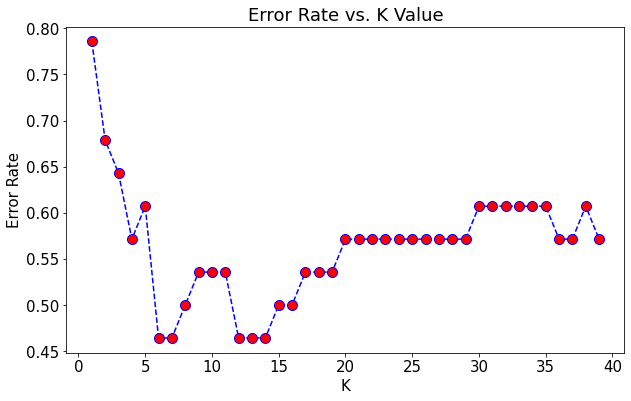

In [54]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [55]:
knn = KNeighborsClassifier(n_neighbors=13).fit(X_train, y_train)

In [56]:
train_results['knn_predicted'] = knn.predict(X_train)
train_results

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted,knn_predicted
26,HTML,JavaScript,HTML,HTML,HTML,HTML,Ruby
135,HTML,HTML,HTML,HTML,HTML,HTML,HTML
77,Ruby,Jupyter Notebook,HTML,Ruby,Ruby,Ruby,Ruby
84,C++,Jupyter Notebook,HTML,C++,C++,C++,C++
1,C,C++,HTML,Python,C,HTML,Ruby
...,...,...,...,...,...,...,...
16,JavaScript,Ruby,HTML,JavaScript,JavaScript,JavaScript,JavaScript
5,C++,JavaScript,HTML,C++,C++,C++,C++
48,JavaScript,Java,HTML,JavaScript,JavaScript,JavaScript,C++
147,C++,Java,HTML,C++,C++,C++,C++


In [57]:
print('K-Nearest Neighbors Model')
print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_results.knn_predicted, train_results.actual))
print('---')
print(classification_report(train_results.actual, train_results.knn_predicted))

K-Nearest Neighbors Model
Accuracy: 65.60%
---
Confusion Matrix
actual         C  C#  C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  \
knn_predicted                                                              
C++            1   0   11    0     0     0           1                 0   
HTML           0   1    0    2    10     0           2                 1   
Java           0   0    2    0     2    16           0                 0   
JavaScript     0   1    3    0     5     0          15                 0   
Python         0   0    2    0     0     0           0                 3   
Ruby           1   0    1    0     3     0           1                 0   

actual         Python  Ruby  Scala  TypeScript  
knn_predicted                                   
C++                 2     0      0           0  
HTML                1     0      0           0  
Java                0     0      1           0  
JavaScript          2     1      0           2  
Python             13     1      

## Validation - Checking for Overfitting

We will check the following models for overfitting:
1) Baseline Random Weighted Choice  
2) Baseline Mode  
3) Logistic Regression  
4) Decision Tree  
5) Random Forest  

### Baseline Model: Weighted Random Selection -  Performance on Validate Set

In [58]:
validate_results = pd.DataFrame(dict(actual=y_validate))

In [59]:
baseline_validate_pred_random = explore.baseline_language_model(train, num_observations = validate.language.shape[0])

In [60]:
validate_results['base_random'] = baseline_validate_pred_random
validate_results.head()

,actual,base_random
100,Python,JavaScript
126,HTML,Java
183,Java,Ruby
98,Python,CSS
20,CSS,Ruby


In [61]:
print('Baseline Model: Weighted Random Selection - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.base_random, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.base_random))

Baseline Model: Weighted Random Selection - VALIDATE SET PERFORMANCE
Accuracy: 6.25%
---
Confusion Matrix
actual            C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
base_random                                                                    
C                   0    0     0     0           1                 0       0   
C#                  1    0     0     0           0                 0       0   
C++                 1    0     0     0           0                 0       0   
CSS                 0    0     0     0           0                 0       1   
HTML                1    0     0     1           0                 0       0   
Java                0    0     3     0           1                 0       1   
JavaScript          0    0     1     1           1                 0       2   
Jupyter Notebook    0    0     0     0           0                 0       0   
Python              2    0     0     0           0                 0       0   
Ruby          

### Baseline Model: Mode Selection - Performance on Validate Set

In [62]:
validate_results['base_mode'] = train.language.value_counts().idxmax()
validate_results.head()

,actual,base_random,base_mode
100,Python,JavaScript,HTML
126,HTML,Java,HTML
183,Java,Ruby,HTML
98,Python,CSS,HTML
20,CSS,Ruby,HTML


In [63]:
print('Baseline Model: Mode Selection - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.base_mode, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.base_mode))

Baseline Model: Mode Selection - VALIDATE SET PERFORMANCE
Accuracy: 15.62%
---
Confusion Matrix
actual     C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  Ruby  \
base_mode                                                                     
HTML         5    1     5     4           5                 1       5     5   

actual     Scala  
base_mode         
HTML           1  
---
                  precision    recall  f1-score   support

             C++       0.00      0.00      0.00         5
             CSS       0.00      0.00      0.00         1
            HTML       0.16      1.00      0.27         5
            Java       0.00      0.00      0.00         4
      JavaScript       0.00      0.00      0.00         5
Jupyter Notebook       0.00      0.00      0.00         1
          Python       0.00      0.00      0.00         5
            Ruby       0.00      0.00      0.00         5
           Scala       0.00      0.00      0.00         1

        accuracy       

### Logistic Regression - Performance on Validate Set

In [64]:
validate_results['lm_predicted'] = lm.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted
100,Python,JavaScript,HTML,Python
126,HTML,Java,HTML,JavaScript
183,Java,Ruby,HTML,Java
98,Python,CSS,HTML,Ruby
20,CSS,Ruby,HTML,JavaScript


In [65]:
print('Logistic Regression - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.lm_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.lm_predicted))

Logistic Regression - VALIDATE SET PERFORMANCE
Accuracy: 34.38%
---
Confusion Matrix
actual        C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
lm_predicted                                                               
C++             2    0     0     1           0                 0       0   
HTML            1    0     1     1           3                 0       1   
Java            0    0     0     1           0                 0       0   
JavaScript      2    1     2     0           2                 0       1   
Python          0    0     0     1           0                 1       1   
Ruby            0    0     2     0           0                 0       2   

actual        Ruby  Scala  
lm_predicted               
C++              1      0  
HTML             0      0  
Java             0      0  
JavaScript       0      0  
Python           0      1  
Ruby             4      0  
---
                  precision    recall  f1-score   support

             C++   

### Decision Tree - Performance on Validate Set

In [66]:
validate_results['clf_predicted'] = clf.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted,clf_predicted
100,Python,JavaScript,HTML,Python,HTML
126,HTML,Java,HTML,JavaScript,HTML
183,Java,Ruby,HTML,Java,Java
98,Python,CSS,HTML,Ruby,Python
20,CSS,Ruby,HTML,JavaScript,C++


In [67]:
print('Decision Tree Model - VALIDATE SET')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.clf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.clf_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.clf_predicted))

Decision Tree Model - VALIDATE SET
Accuracy: 34.38%
---
Confusion Matrix
actual         C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
clf_predicted                                                               
C                0    0     0     1           1                 0       0   
C++              0    1     1     0           1                 0       0   
HTML             3    0     2     0           2                 0       2   
Java             1    0     0     2           0                 0       0   
JavaScript       1    0     1     1           0                 0       0   
Python           0    0     0     0           1                 1       3   
Ruby             0    0     1     0           0                 0       0   

actual         Ruby  Scala  
clf_predicted               
C                 0      0  
C++               0      0  
HTML              1      0  
Java              0      0  
JavaScript        0      0  
Python            0      1  
R

### Random Forest - Performance on Validate Set

In [68]:
validate_results['rf_predicted'] = rf.predict(X_validate)
validate_results.head()

,actual,base_random,base_mode,lm_predicted,clf_predicted,rf_predicted
100,Python,JavaScript,HTML,Python,HTML,C++
126,HTML,Java,HTML,JavaScript,HTML,HTML
183,Java,Ruby,HTML,Java,Java,Java
98,Python,CSS,HTML,Ruby,Python,Ruby
20,CSS,Ruby,HTML,JavaScript,C++,JavaScript


In [69]:
print('Random Forest - VALIDATE SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate_results.rf_predicted, validate_results.actual))
print('---')
print(classification_report(validate_results.actual, validate_results.rf_predicted))

Random Forest - VALIDATE SET PERFORMANCE
Accuracy: 31.25%
---
Confusion Matrix
actual        C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
rf_predicted                                                               
C++             0    0     0     0           0                 0       1   
HTML            2    0     2     2           1                 0       1   
Java            0    0     0     1           0                 0       1   
JavaScript      2    1     0     0           3                 0       0   
Python          0    0     2     0           1                 1       1   
Ruby            1    0     1     1           0                 0       1   

actual        Ruby  Scala  
rf_predicted               
C++              0      0  
HTML             1      0  
Java             1      0  
JavaScript       0      0  
Python           0      1  
Ruby             3      0  
---
                  precision    recall  f1-score   support

             C++       0.

## Testing top Performing Model
1) Baseline Model: Weighted Random Selection  
2) Baseline Model: Mode Selection    
3) Logistic Regression

### Baseline Model: Weighted Random Selection - Performance on Test Set

In [70]:
test_results = pd.DataFrame(dict(actual=y_test))

In [71]:
baseline_test_pred_random = explore.baseline_language_model(train, num_observations = test.language.shape[0])

In [72]:
test_results['base_random'] = baseline_test_pred_random
test_results.head()

,actual,base_random
177,Java,Python
50,TypeScript,HTML
167,Java,HTML
129,HTML,Python
114,Ruby,Jupyter Notebook


In [73]:
print('Baseline Model: Weighted Random Selection - TEST SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.base_random)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.base_random, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.base_random))

Baseline Model: Weighted Random Selection - TEST SET PERFORMANCE
Accuracy: 10.71%
---
Confusion Matrix
actual            C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
base_random                                                                    
C                   1    0     0     0           0                 0       0   
C#                  0    0     2     0           0                 0       0   
C++                 0    0     0     0           0                 0       1   
HTML                1    0     0     2           0                 1       2   
Java                2    0     0     0           0                 0       0   
JavaScript          0    0     0     0           2                 0       1   
Jupyter Notebook    0    0     0     0           0                 0       0   
Python              0    1     1     1           0                 0       0   
Ruby                0    0     1     1           2                 0       0   
Scala            

### Baseline Model: Mode Selection - Performance on Test Set

In [74]:
test_results['base_mode'] = train.language.value_counts().idxmax()
test_results.head()

,actual,base_random,base_mode
177,Java,Python,HTML
50,TypeScript,HTML,HTML
167,Java,HTML,HTML
129,HTML,Python,HTML
114,Ruby,Jupyter Notebook,HTML


In [75]:
print('Baseline Model: Mode Selection - TEST SET PERFORMANCE')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.base_mode)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.base_mode, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.base_mode))

Baseline Model: Mode Selection - TEST SET PERFORMANCE
Accuracy: 17.86%
---
Confusion Matrix
actual     C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  Ruby  \
base_mode                                                                     
HTML         4    1     5     4           4                 1       4     4   

actual     TypeScript  
base_mode              
HTML                1  
---
                  precision    recall  f1-score   support

             C++       0.00      0.00      0.00         4
             CSS       0.00      0.00      0.00         1
            HTML       0.18      1.00      0.30         5
            Java       0.00      0.00      0.00         4
      JavaScript       0.00      0.00      0.00         4
Jupyter Notebook       0.00      0.00      0.00         1
          Python       0.00      0.00      0.00         4
            Ruby       0.00      0.00      0.00         4
      TypeScript       0.00      0.00      0.00         1

        accu

### Logistic Regression - Performance on Test Set

In [76]:
test_results['lm_predicted'] = lm.predict(X_test)
test_results.head()

,actual,base_random,base_mode,lm_predicted
177,Java,Python,HTML,HTML
50,TypeScript,HTML,HTML,C++
167,Java,HTML,HTML,Java
129,HTML,Python,HTML,JavaScript
114,Ruby,Jupyter Notebook,HTML,HTML


In [77]:
print('Logistic Regression Model - TEST SET')
print('Accuracy: {:.2%}'.format(accuracy_score(test_results.actual, test_results.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test_results.lm_predicted, test_results.actual))
print('---')
print(classification_report(test_results.actual, test_results.lm_predicted))

Logistic Regression Model - TEST SET
Accuracy: 50.00%
---
Confusion Matrix
actual        C++  CSS  HTML  Java  JavaScript  Jupyter Notebook  Python  \
lm_predicted                                                               
C++             2    0     0     0           0                 0       0   
HTML            0    0     3     1           2                 0       0   
Java            0    0     0     3           0                 0       0   
JavaScript      0    1     2     0           1                 0       1   
Python          2    0     0     0           0                 1       3   
Ruby            0    0     0     0           1                 0       0   

actual        Ruby  TypeScript  
lm_predicted                    
C++              0           1  
HTML             1           0  
Java             0           0  
JavaScript       1           0  
Python           0           0  
Ruby             2           0  
---
                  precision    recall  f1-score 

# Conclusion